In [29]:
import time

import heapq
import random
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
from geopy.distance import geodesic

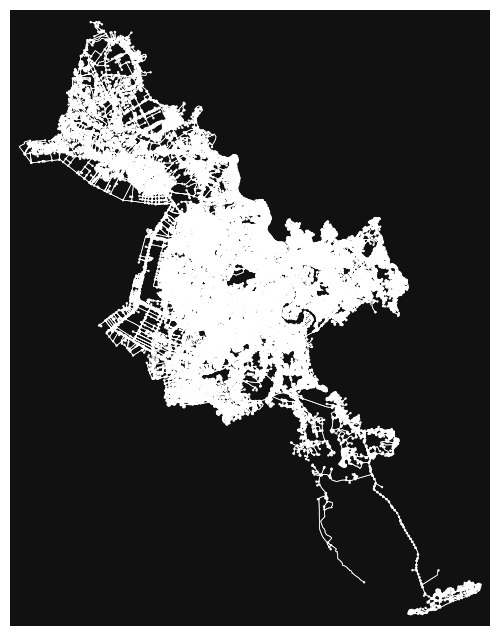

In [5]:
# ---------- Load Ho Chi Minh City graph ----------
G = ox.graph_from_place('Ho Chi Minh City, Vietnam', network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
ox.plot_graph(G, node_size=3, edge_color='white', edge_linewidth=0.5)
plt.show()

In [26]:
# ---------- Define known locations ----------
start_gdf = ox.geocode_to_gdf('Thu Duc Market, Ho Chi Minh City')
if start_gdf.geometry.iloc[0].geom_type == 'Point':
    start_point = start_gdf.geometry.iloc[0]
else:
    start_point = start_gdf.geometry.iloc[0].centroid

goal_gdf = ox.geocode_to_gdf('Ben Thanh Market, Ho Chi Minh City')
if goal_gdf.geometry.iloc[0].geom_type == 'Point':
    goal_point = goal_gdf.geometry.iloc[0]
else:
    goal_point = goal_gdf.geometry.iloc[0].centroid

start_node = ox.distance.nearest_nodes(G, X=start_point.x, Y=start_point.y)
goal_node = ox.distance.nearest_nodes(G, X=goal_point.x, Y=goal_point.y)
print(f"Start node: {start_node} (Thu Duc Market), Goal node: {goal_node} (Ben Thanh Market)")


Start node: 366463208 (Thu Duc Market), Goal node: 2899065691 (Ben Thanh Market)


In [27]:
# ---------- Heuristic (vector-based) ----------
def heuristic_vector(a, b):
    coord_a = (G.nodes[a]['y'], G.nodes[a]['x'])
    coord_b = (G.nodes[b]['y'], G.nodes[b]['x'])
    straight_line = geodesic(coord_a, coord_b).meters
    time_estimate = straight_line / 13.89  # assume ~50 km/h average speed (13.89 m/s)
    
    # Add random factor to simulate dynamic, uncertain heuristic
    noise_distance = random.uniform(-0.1 * straight_line, 0.1 * straight_line)  # ±10%
    noise_time = random.uniform(-0.1 * time_estimate, 0.1 * time_estimate)

    return [straight_line + noise_distance, time_estimate + noise_time]


In [22]:
# ---------- Combine vector f using weights ----------
def combine_f(g_vector, h_vector, weight_distance=0.7, weight_time=0.3):
    return weight_distance * (g_vector[0] + h_vector[0]) + weight_time * (g_vector[1] + h_vector[1])

In [14]:
# ---------- Path Reconstruction ----------
def reconstruct_path(came_from, current):
    path = [current]
    while current in came_from:
        current = came_from[current]
        path.append(current)
    path.reverse()
    return path

In [23]:
# ---------- A* Algorithm ----------
def astar(G, start, goal):
    open_set = []
    heapq.heappush(open_set, (0, start))
    came_from = {}

    g_score = {node: [float('inf'), float('inf')] for node in G.nodes}  # [distance, time]
    g_score[start] = [0, 0]

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = combine_f(g_score[start], heuristic_vector(start, goal))

    visited = set()

    while open_set:
        _, current = heapq.heappop(open_set)

        if current == goal:
            return reconstruct_path(came_from, current)

        if current in visited:
            continue
        visited.add(current)

        for neighbor in G.neighbors(current):
            edge_data = G.get_edge_data(current, neighbor)[0]
            edge_distance = edge_data['length']
            edge_time = edge_data['travel_time']

            tentative_g = [
                g_score[current][0] + edge_distance,
                g_score[current][1] + edge_time
            ]

            if tentative_g[0] < g_score[neighbor][0]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = combine_f(tentative_g, heuristic_vector(neighbor, goal))
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return None

A* algorithm runtime: 0.65 seconds
Path found with 108 nodes.

A* path length: 13140.86 m, NetworkX path length: 12973.56 m
Length difference: 167.29 m (1.29% difference)
A* path is close to NetworkX shortest path (within 5%).


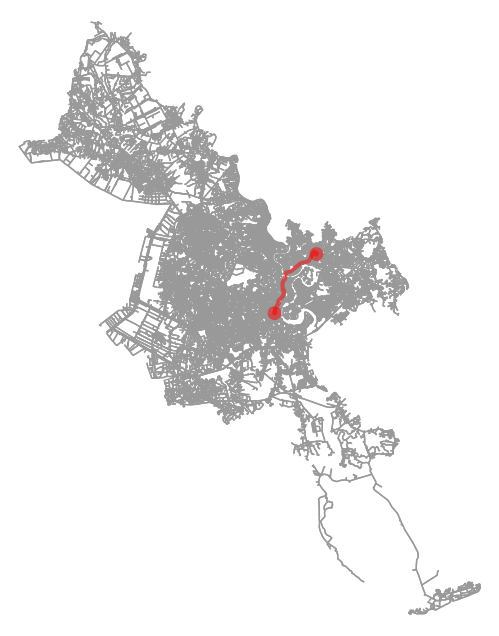

In [32]:
# ---------- Run A* ----------
start_time = time.time()
path = astar(G, start_node, goal_node)
end_time = time.time()
runtime = end_time - start_time
print(f"A* algorithm runtime: {runtime:.2f} seconds")
if path:
    print(f"Path found with {len(path)} nodes.\n")

    # ---------- Testing correctness ----------
    # Example check: compare path length and time to NetworkX shortest path
    try:
        nx_shortest = nx.shortest_path(G, start_node, goal_node, weight='length')
        a_star_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(path[:-1], path[1:]))
        nx_length = sum(G.edges[u, v, 0]['length'] for u, v in zip(nx_shortest[:-1], nx_shortest[1:]))
        
        length_diff = abs(a_star_length - nx_length)
        percent_diff = (length_diff / nx_length) * 100

        print(f"A* path length: {a_star_length:.2f} m, NetworkX path length: {nx_length:.2f} m")
        print(f"Length difference: {length_diff:.2f} m ({percent_diff:.2f}% difference)")

        if percent_diff < 5:
            print("A* path is close to NetworkX shortest path (within 5%).")
        else:
            print("A* path differs significantly from NetworkX shortest path.")

    except Exception as e:
        print(f"Could not compute NetworkX shortest path for comparison: {e}")

    ox.plot_graph_route(G, path, route_linewidth=3, node_size=0, bgcolor='white')

else:
    print("No path found.")